# 2 - Training

Before doing anything let us just create paths to aur folders so our work remains manageable and understandable. 

In [1]:
PATH_TO_IMAGES_FOLDER='images'
PATH_TO_ANNOTATIONS_FOLDER='annotations'

## Clean XML files

The command bellow will run the xmlconversion.py script. This script creates a new directory called cleaned inside images directory which contains cleaned XML files (remves all un-necessary spaces).
(Only need to run this command if using any labeling module other than the recommended ('labelimg'))

## Train-Test Partition

To keep the model from being biased, we need to evaluate it on unseen data. For this purpose we will divide the dataset into two parts, train and test. The training partition will be used to train the model, and the test partition, being unseen to the model, will be used to evaluate the model performance. The below line will run partition_dataset.py file which will select a percentage (10% in this case) of images and corresponding xmls, in random order, from the images folder and create a new subfolder named test with these images coppied in it. The remaining images will be coppied to a subfolder called train.

In [12]:
!python partition_dataset.py -x -i ./{PATH_TO_IMAGES_FOLDER} -r 0.1

## Create the TF Record

Object Detection API rquires the images to be stored in the binary form in a TFRecords file which makes the training faster and easier for the machine as it takes less memory.

### Create the .PBTXT file

As Object Detection API requires us to assign numeric labels to each object to be detected, we need to create a PBTX file that contains these labels for the four birds species, namely, Erithacus Rubecula, Periparus Ater, Pica Pica, and Turdus Merula. The cell below, when run, creates a numeric 'id' for each bird 'name'.

In [3]:
labels = [{'name':'Erithacus_Rubecula', 'id':1}, {'name':'Periparus_ater', 'id':2},
         {'name':'Pica_pica', 'id':3}, {'name':'Turdus_merula', 'id':4}]

with open('annotations/label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [4]:
# Verify the created PBTX file by opening it in VS Code
!code {PATH_TO_ANNOTATIONS_FOLDER}'/label_map.pbtxt'

### Create the TF Record (Train)

In [15]:
!python generate_tfrecord.py -x {PATH_TO_IMAGES_FOLDER}/train -l {PATH_TO_ANNOTATIONS_FOLDER}/label_map.pbtxt -o {PATH_TO_ANNOTATIONS_FOLDER}/train.record

Successfully created the TFRecord file: annotations/train.record


### Create the TF Record (Test)

In [16]:
!python generate_tfrecord.py -x {PATH_TO_IMAGES_FOLDER}/test -l {PATH_TO_ANNOTATIONS_FOLDER}/label_map.pbtxt -o {PATH_TO_ANNOTATIONS_FOLDER}/test.record

Successfully created the TFRecord file: annotations/test.record


# Training the models

## A - Faster RCNN ResNet 101 (1024x1024)

## Hyperparameters

In the pipeline configuration file we will have to change the values of certain hyperparameters and add paths to certain folders to train our model.

The first thing to do is to provide the path to the checkpoint for transfer learning. This is done by adding the path of the checkpoint from the downloaded pre-trained model to the fine tune checkpoint option in the pipeline configuration file and set fine tune checkpoint type to 'detection'.

######  fine_tune_checkpoint: "pre-trained-models/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/checkpoint/ckpt-0" 

***fine_tune_checkpoint_type: "detection"***

Similarly add paths of the train and evaluation records and the label maps in the configuration file

###### train_input_reader {
######  label_map_path: "annotations/label_map.pbtxt"
######  tf_record_input_reader {
######    input_path: "annotations/train.record"
######  }
###### }
###### eval_input_reader {
######  label_map_path: "annotations/label_map.pbtxt"
######  shuffle: false
######  num_epochs: 1
######  tf_record_input_reader {
######    input_path: "annotations/test.record"
######  }
###### }

Also set the evaluation metrics to ***'coco_detection_metrics'*** and at the very start of the file, set the number of classes for detection to ***4*** as we will be detecting four types of birds.

The batch size is set to ***1*** owing to the memory constrainints.

The most important hyper-parameter is learning rate. To set the learning rate, we have to test the model at various values and observe the loss curves at the tensor board and select the one that gives best results. This is done by trial and error method.If the learning rate is too large the model will the loss curve will explode and the model might never converge and at too small learning rate, it will take the model forever to converge. Fot this task the learning rate is set to ***0.0006*** and warmup learning rate to ***0.00006***. The total steps for the momentum optimizer are set to be 200000 out of which the first 5000 steps will have a high rate of increse in the learning rate from 0.00006 to 0.0006 and then it will reduce slowly so as to reduce the loss.

In [3]:
PATH_TO_MODEL='Faster_RCNN_ResNet101_1024x1024'

In [4]:
!code models/{PATH_TO_MODEL}/pipeline.config

In [11]:
!python model_main_tf2.py --model_dir=models/{PATH_TO_MODEL} --pipeline_config_path=models/{PATH_TO_MODEL}/pipeline.config --num_train_steps=33000 --alsologtostderr

2022-12-31 22:19:58.391152: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-31 22:19:59.655948: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-31 22:19:59.704002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 22:19:59.704464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-12-31 22:19:59.704481: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-31 22:19:59.706041: I tensorflow/stream_executor/

Instructions for updating:
Use `tf.data.Dataset.map()
W1231 22:20:00.188733 140656170435392 deprecation.py:330] From /home/msc1/anaconda3/envs/Object-Detection-API/lib/python3.8/site-packages/object_detection/builders/dataset_builder.py:236: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W1231 22:20:03.823874 140656170435392 deprecation.py:330] From /home/msc1/anaconda3/envs/Object-Detection-API/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use `tf.cast` instead.
W1231 22:20:06.215297 140656170

INFO:tensorflow:Step 31400 per-step time 0.106s
I1231 22:21:35.756338 140656170435392 model_lib_v2.py:698] Step 31400 per-step time 0.106s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.045189515,
 'Loss/BoxClassifierLoss/localization_loss': 0.15992273,
 'Loss/RPNLoss/localization_loss': 0.0,
 'Loss/RPNLoss/objectness_loss': 6.317139e-05,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.20517541,
 'learning_rate': 0.00057327165}
I1231 22:21:35.756488 140656170435392 model_lib_v2.py:701] {'Loss/BoxClassifierLoss/classification_loss': 0.045189515,
 'Loss/BoxClassifierLoss/localization_loss': 0.15992273,
 'Loss/RPNLoss/localization_loss': 0.0,
 'Loss/RPNLoss/objectness_loss': 6.317139e-05,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.20517541,
 'learning_rate': 0.00057327165}
INFO:tensorflow:Step 31500 per-step time 0.107s
I1231 22:21:46.435473 140656170435392 model_lib_v2.py:698] Step 31500 per-step time 0.107s
INFO:tensorflow:{'Loss/BoxClassifierLoss/

INFO:tensorflow:Step 32100 per-step time 0.113s
I1231 22:22:51.199893 140656170435392 model_lib_v2.py:698] Step 32100 per-step time 0.113s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.011863398,
 'Loss/BoxClassifierLoss/localization_loss': 0.061266106,
 'Loss/RPNLoss/localization_loss': 0.0,
 'Loss/RPNLoss/objectness_loss': 0.0029335397,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.076063044,
 'learning_rate': 0.0005718583}
I1231 22:22:51.200059 140656170435392 model_lib_v2.py:701] {'Loss/BoxClassifierLoss/classification_loss': 0.011863398,
 'Loss/BoxClassifierLoss/localization_loss': 0.061266106,
 'Loss/RPNLoss/localization_loss': 0.0,
 'Loss/RPNLoss/objectness_loss': 0.0029335397,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.076063044,
 'learning_rate': 0.0005718583}
INFO:tensorflow:Step 32200 per-step time 0.107s
I1231 22:23:01.884448 140656170435392 model_lib_v2.py:698] Step 32200 per-step time 0.107s
INFO:tensorflow:{'Loss/BoxClassifierLos

The training is done in parts, evaluating the model after every few steps. The model strats giving resonable loss values after 20000 steps of training, and good precion values around 30000 steps and starts to converge.So the training was stoped after 33000 steps. The mAp @ 50 IOU is 91.1% and @ 75 IOU is 75.9%. To help understand these values, grpahs for the total training loss and mAP are attached bellow. The remaining graphs are accessable in the tensorboard notebook using logs as well as screenshots in the same notebook.

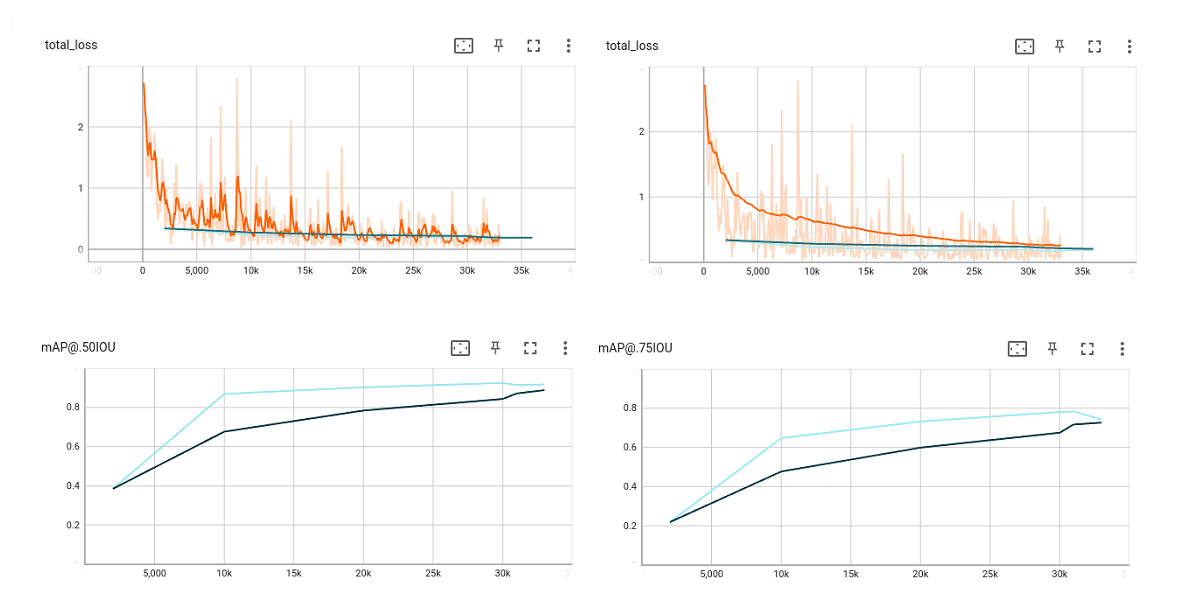

In [1]:
from IPython.display import Image
Image(filename='tensorboard_plots/Faster_RCNN/Loss_mAP(IOU).jpg')

## Inference Graph

To use this model in future, we need to freeze the model and save it. For this purpose, we create the inference graph using exporter_main_v2.py file which will save the weights, config file, checkpoints and the model .pb file in a separate folder. 

In [14]:
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path models/{PATH_TO_MODEL}/pipeline.config --trained_checkpoint_dir models/{PATH_TO_MODEL}/ --output_directory exported-models/{PATH_TO_MODEL}

2022-12-25 02:25:33.354264: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-25 02:25:34.450281: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-25 02:25:34.479353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 02:25:34.479721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-12-25 02:25:34.479736: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-25 02:25:34.481270: I tensorflow/stream_executor/

/home/msc1/anaconda3/envs/Object-Detection-API/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
W1225 02:26:07.668989 140631385133440 save.py:1239] FOR KERAS USERS: The object that you are saving contains one or more Keras models or layers. If you are loading the SavedModel with `tf.keras.models.load_model`, continue reading (otherwise, you may ignore the following instructions). Please change your code to save with `tf.keras.models.save_model` or `model.save`, and confirm that the file "keras.metad

## B - SSD ResNet 101 (1024x1024)

## Hyperparameters

Just as the pervious model, we set the hyperparameters in the config file. The path to the pretrained model checkpoint is set for the SSD model and set fine tune checkpoint type to 'detection'.

######  fine_tune_checkpoint: "pre-trained-models/ssd_resnet101_v1_fpn_1024x1024_coco17_tpu-8/checkpoint/ckpt-0" 

***fine_tune_checkpoint_type: "detection"***

Similarly add paths of the train and evaluation records and the label maps in the configuration file

###### train_input_reader {
######  label_map_path: "annotations/label_map.pbtxt"
######  tf_record_input_reader {
######    input_path: "annotations/train.record"
######  }
###### }
###### eval_input_reader {
######  label_map_path: "annotations/label_map.pbtxt"
######  shuffle: false
######  num_epochs: 1
######  tf_record_input_reader {
######    input_path: "annotations/test.record"
######  }
###### }

Also set the evaluation metrics to ***'coco_detection_metrics'*** and at the very start of the file, set the number of classes for detection to ***4*** as we will be detecting four types of birds.

The batch size is set to ***2*** instead of 64 owing to the memory constrainints.

(After training the SSD model with the original birds images dataset, the precions metrics were not good. The images were agumented to train the model again.)

Using trial and error method the learning rate is set to ***0.00003*** and warmup learning rate to ***0.000003***. Choosing a lower value, the model takes so long to reduce the loss and go towards convergence. The total steps for the momentum optimizer are set to be 100000 out of which the first 5000 steps will have a high rate of increse in the learning rate from 0.000003 to 0.00003 and then it will reduce slowly using cosine decay so as to reduce the loss.

In [3]:
PATH_TO_MODEL='SSD_ResNet101_Aug_Birds_1024x1024'
PATH_EXPORT_MODEL = 'exported-models/SSD_ResNet101_Aug_Birds_1024x1024'

In [5]:
!code models/{PATH_TO_MODEL}/pipeline.config

## Training

In [16]:
!python model_main_tf2.py --model_dir=models/{PATH_TO_MODEL} --pipeline_config_path=models/{PATH_TO_MODEL}/pipeline.config --num_train_steps=36100 --alsologtostderr

2022-12-22 01:50:20.250472: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-22 01:50:21.536416: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-22 01:50:21.577404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 01:50:21.577872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-12-22 01:50:21.577888: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-22 01:50:21.579511: I tensorflow/stream_executor/

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W1222 01:50:25.490315 139752315228544 deprecation.py:330] From /home/msc1/anaconda3/envs/Object-Detection-API/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
W1222 01:50:27.015216 139752315228544 deprecation.py:330] From /home/msc1/anaconda3/envs/Object-Detection-API/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instruct

The training steps are chosen to be 36100. To train the model and observe the train and evaluation loss at the same time on the TensorBoard, training is done in small steps of 5000 and evaluation script is run after each of these intervals. The model started giving resonable loss value after 30000 steps and started to converge. The other reason to choose this value of steps is the Average precision. We start getting 90.2% mAp @50IOU and 68.4% mAp @75IOU on evaluationg at 36000 steps so the training was stopped at 36100. The graphs below show the same results.

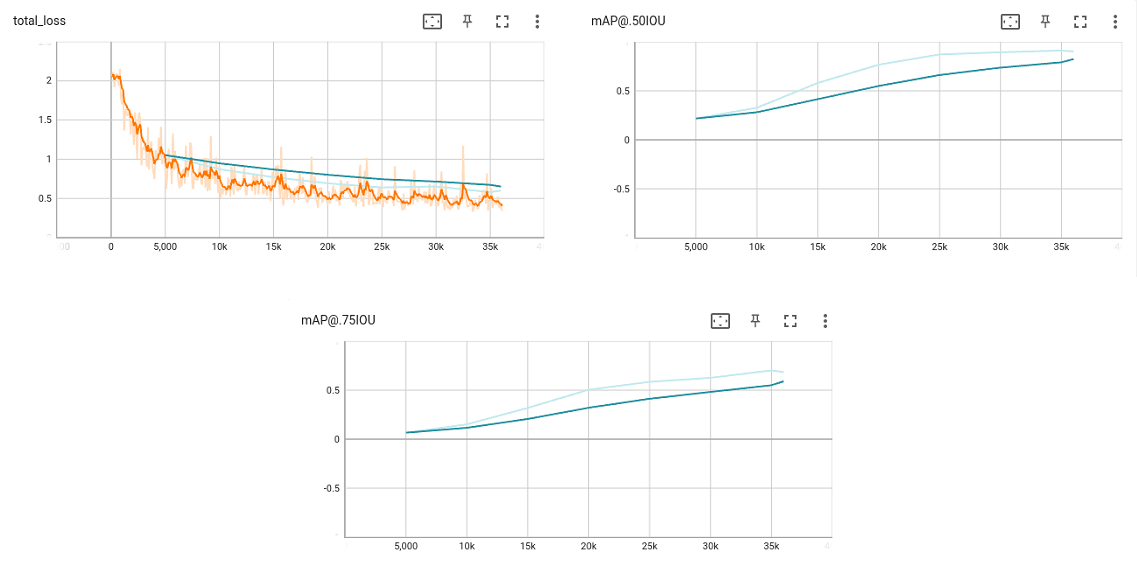

In [3]:
from IPython.display import Image
Image(filename='tensorboard_plots/SSD/Loss/map_loss.png')

## Inference Graph

To use this model in future, we need to freeze the model and save it. For this purpose, we create the inference graph using exporter_main_v2.py file which will save the weights, config file, checkpoints and the model .PB file in a separate folder. 

In [17]:
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path models/{PATH_TO_MODEL}/pipeline.config --trained_checkpoint_dir models/{PATH_TO_MODEL}/ --output_directory exported-models/{PATH_TO_MODEL}

2022-12-22 02:06:48.856122: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-22 02:06:49.901898: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-22 02:06:49.924774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 02:06:49.925223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-12-22 02:06:49.925238: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-12-22 02:06:49.926825: I tensorflow/stream_executor/

INFO:tensorflow:Assets written to: exported-models/SSD_ResNet101_Aug_Birds_1024x1024/saved_model/assets
I1222 02:07:33.649651 139835246920064 builder_impl.py:774] Assets written to: exported-models/SSD_ResNet101_Aug_Birds_1024x1024/saved_model/assets
INFO:tensorflow:Writing pipeline config file to exported-models/SSD_ResNet101_Aug_Birds_1024x1024/pipeline.config
I1222 02:07:34.524913 139835246920064 config_util.py:253] Writing pipeline config file to exported-models/SSD_ResNet101_Aug_Birds_1024x1024/pipeline.config
